# Metric Analysis with Full Dataframe

2025-04-13 18:21:21,902 - INFO - Searching for analysis files in: /Users/ptr/Documents/Projects/AnomaLLMy/analyzer/analysis_results
2025-04-13 18:21:21,903 - INFO - Starting file processing...
2025-04-13 18:21:21,905 - INFO - Finished file processing. Found 9. Processed data from 9 files.
2025-04-13 18:21:21,907 - INFO - Initial DataFrame: 9 entries.
2025-04-13 18:21:21,908 - INFO - Aggregating metrics by original LLM name...
2025-04-13 18:21:21,910 - INFO - Aggregated DataFrame: 9 unique LLMs.
2025-04-13 18:21:21,910 - INFO - Generated simplified LLM aliases.
2025-04-13 18:21:21,911 - INFO - Final Aggregated DataFrame for plotting:
2025-04-13 18:21:21,913 - INFO - Data types:
/var/folders/7d/sh551ddj3cxdktjdc_j0xby00000gn/T/ipykernel_1139/147390966.py:143: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cma

                                                                          LLM  Total Response Time  Average Response Rate  Total Word Count  Total Character Count  Total Sentence Count  Average Word Length  Average Sentence Length  Average Vocabulary Richness                                                     LLM_Alias
0                                                           dolphin-llama3:8b                64.95                  20.84            1268.0                 8567.0                 145.0                 6.76                     8.74                       0.5496                                           dolphin-llama3 (8B)
1                                                                   gemma2:2b                45.22                  49.48            2218.0                16293.0                 163.0                 7.35                    13.61                       0.5230                                                   gemma2 (2B)
2                                 

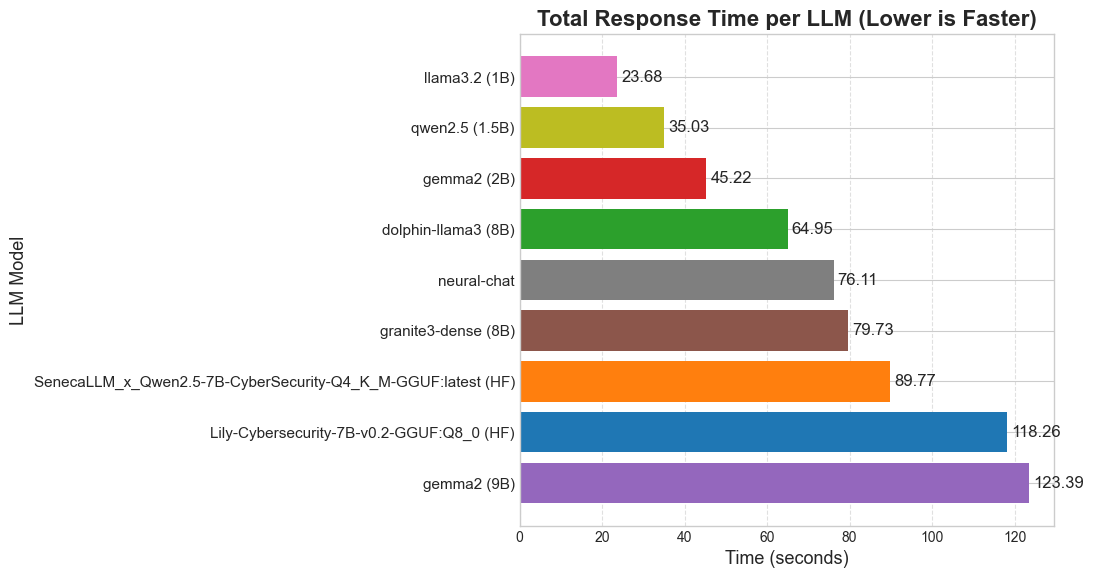

2025-04-13 18:21:21,972 - INFO - Plotting 'Average Response Rate per LLM (Higher is Faster)' for 9 models (Sorted Asc: False)


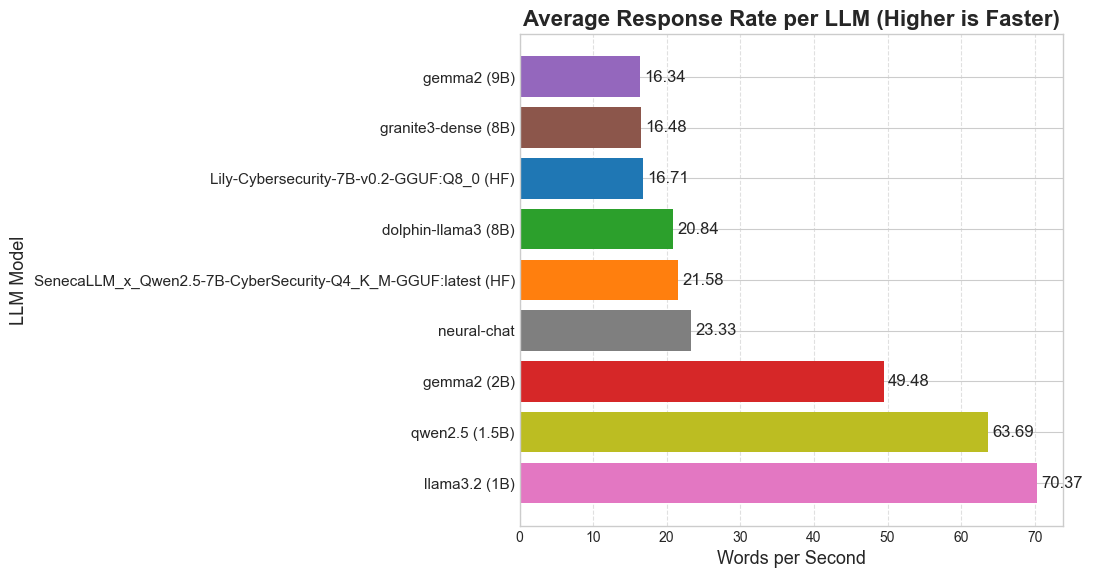

2025-04-13 18:21:22,019 - INFO - Plotting 'Total Word Count per LLM (Higher is More Verbose)' for 9 models (Sorted Asc: True)


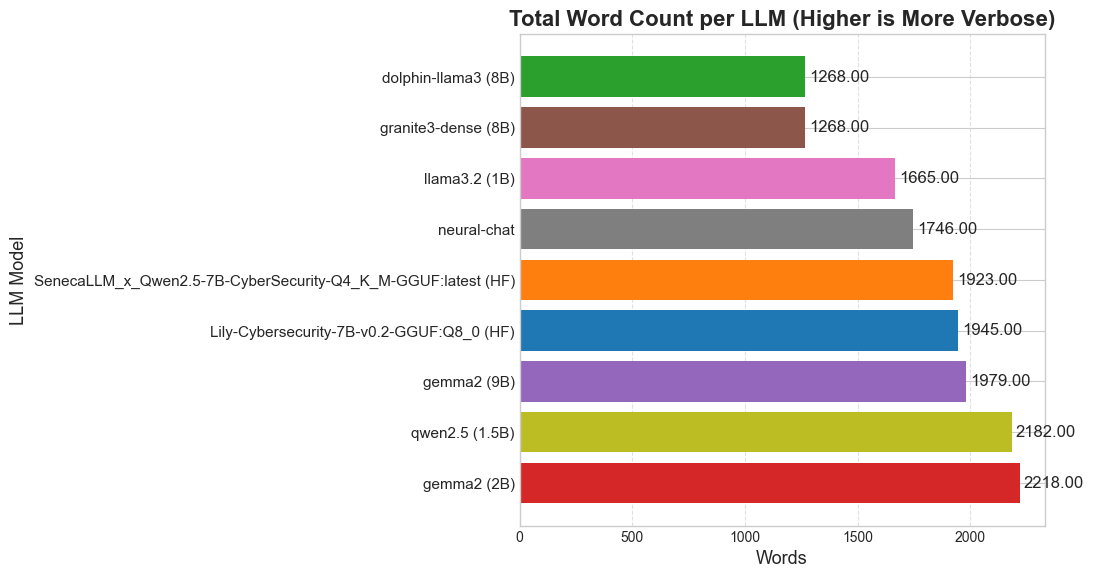

2025-04-13 18:21:22,061 - INFO - Plotting 'Total Character Count per LLM (Higher is More Verbose)' for 9 models (Sorted Asc: True)


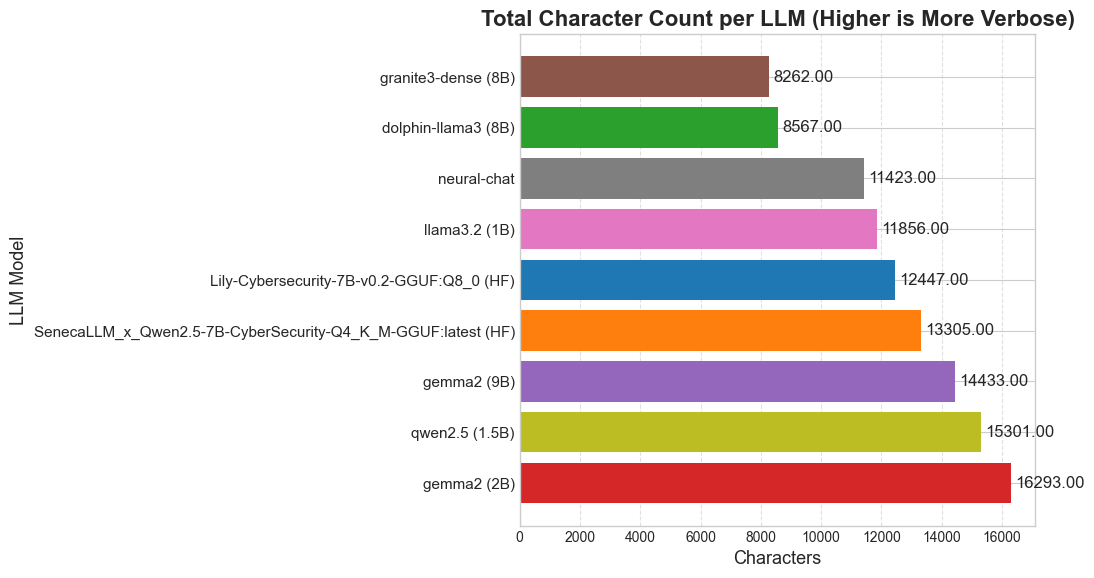

2025-04-13 18:21:22,106 - INFO - Plotting 'Total Sentence Count per LLM (Higher is More Verbose)' for 9 models (Sorted Asc: True)


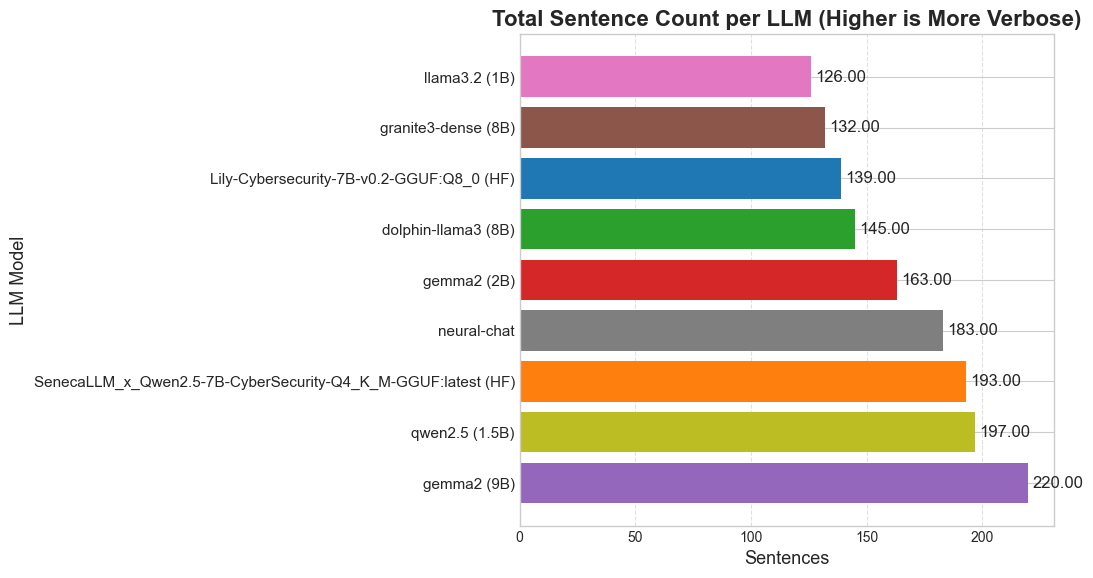

2025-04-13 18:21:22,151 - INFO - Plotting 'Average Word Length per LLM' for 9 models (Sorted Asc: True)


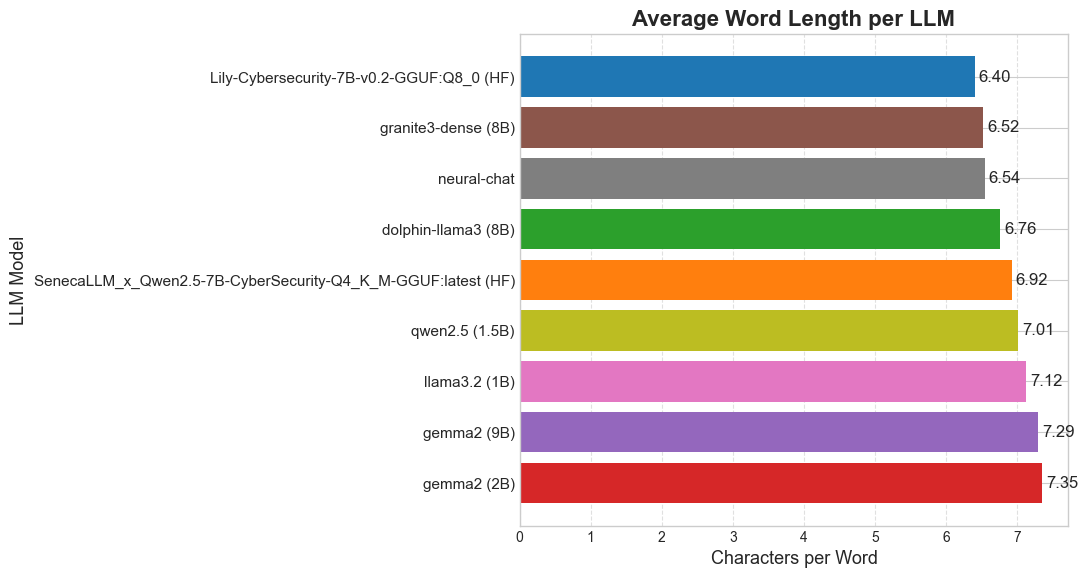

2025-04-13 18:21:22,193 - INFO - Plotting 'Average Sentence Length per LLM' for 9 models (Sorted Asc: True)


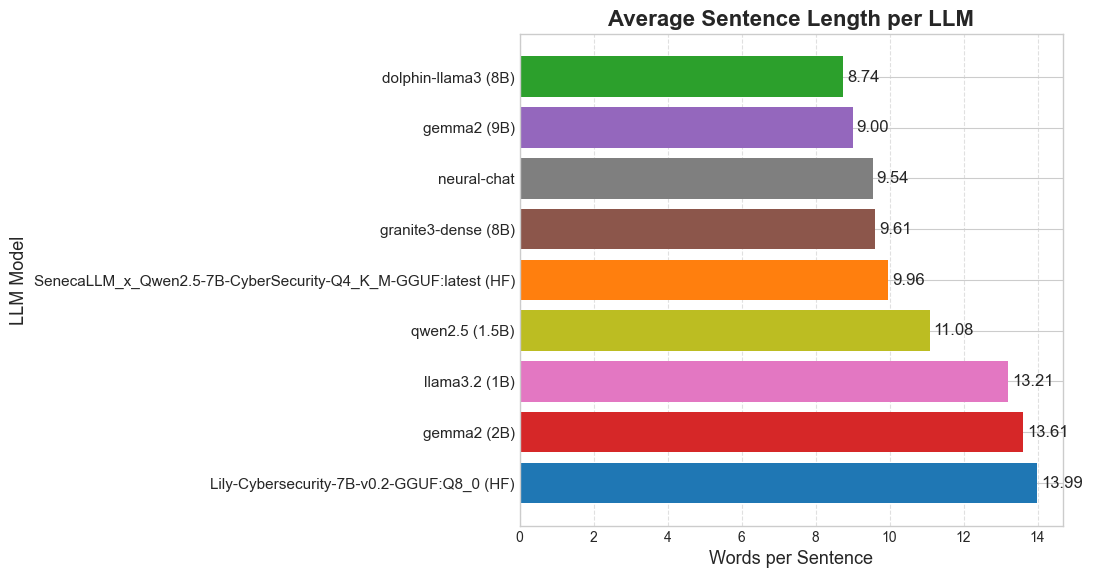

2025-04-13 18:21:22,236 - INFO - Plotting 'Average Vocabulary Richness per LLM' for 9 models (Sorted Asc: True)


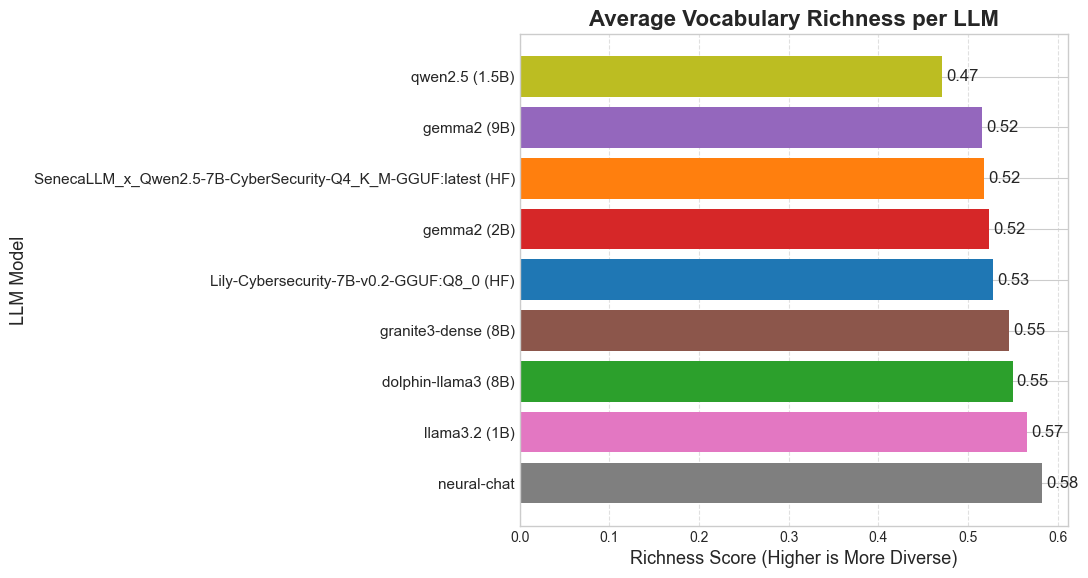

In [12]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import matplotlib.cm as cm # Import colormaps

# --- Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
analysis_results_dir = '../analyzer/analysis_results/'

# --- Function to Simplify LLM Names ---
# (Keep the simplify_llm_name function exactly as defined in the previous version)
def simplify_llm_name(name):
    name = str(name).strip()
    hf_match = re.match(r'^hf\.co\/[^/]+\/(.*)', name)
    if hf_match:
        model_part = hf_match.group(1)
        # Optional cleaning
        # model_part = re.sub(r'[-_]GGUF.*', '', model_part, flags=re.IGNORECASE)
        return f"{model_part} (HF)"
    else:
        parts = name.split(':')
        base_name = parts[0]
        tag = parts[1] if len(parts) > 1 else None
        size_match = re.search(r'(\d+(\.\d+)?[bB])', base_name)
        if size_match:
            size = size_match.group(0).upper()
            clean_base = re.sub(r'[\-:\.]?' + re.escape(size_match.group(0)) + r'$', '', base_name, flags=re.IGNORECASE).strip(':-.')
            clean_base = clean_base if clean_base else base_name
            return f"{clean_base} ({size})"
        elif tag:
             size_match_tag = re.search(r'(\d+(\.\d+)?[bB])', tag)
             if size_match_tag:
                 size = size_match_tag.group(0).upper()
                 return f"{base_name} ({size})"
             else:
                 return f"{base_name}"
        else:
             return base_name
    return name

# --- Path Validation ---
analysis_results_dir = os.path.abspath(analysis_results_dir)
if not os.path.isdir(analysis_results_dir):
    logging.error(f"Error: The directory {analysis_results_dir} does not exist.")
    raise FileNotFoundError(f"Directory not found: {analysis_results_dir}")
else:
    logging.info(f"Searching for analysis files in: {analysis_results_dir}")

# --- Data Extraction ---
# (Keep the data extraction loop exactly as defined in the previous version)
llm_names = []
response_times = []
response_rates = []
word_counts = []
char_counts = []
sentence_counts = []
avg_word_lengths = []
avg_sentence_lengths = []
vocab_richnesses = []
metrics_regex = {
    'Total Elapsed Time': r"Total Elapsed Time:\s*([\d.]+)",
    'Average Response Rate': r"Average Response Rate:\s*([\d.]+)",
    'Total Word Count': r"Total Word Count:\s*(\d+)",
    'Total Character Count': r"Total Character Count:\s*(\d+)",
    'Total Sentence Count': r"Total Sentence Count:\s*(\d+)",
    'Average Word Length': r"Average Word Length:\s*([\d.]+)",
    'Average Sentence Length': r"Average Sentence Length:\s*([\d.]+)",
    'Average Vocabulary Richness': r"Average Vocabulary Richness:\s*([\d.]+)"
}
model_name_regex = r"Model Used:\s*(.*)"
found_files = 0
processed_files = 0
logging.info("Starting file processing...")
for filename in os.listdir(analysis_results_dir):
    if filename.endswith('.txt') and ('_analysis_' in filename or 'metrics_' in filename):
        found_files += 1
        file_path = os.path.join(analysis_results_dir, filename)
        logging.debug(f"Processing file: {filename}")
        try:
            with open(file_path, 'r', encoding='utf-8') as file: content = file.read()
            model_match = re.search(model_name_regex, content)
            if not model_match: logging.warning(f"No 'Model Used:' in {filename}. Skip."); continue
            llm_name = model_match.group(1).strip();
            if not llm_name: logging.warning(f"'Model Used:' empty in {filename}. Skip."); continue
            extracted_metrics = {}; metrics_found_and_valid = True
            for key, regex in metrics_regex.items():
                match = re.search(regex, content)
                if match:
                    value_str = match.group(1)
                    try: extracted_metrics[key] = float(value_str)
                    except ValueError: logging.warning(f"Bad value '{value_str}' for '{key}' in {filename}. Skip."); metrics_found_and_valid = False; break
                else: logging.warning(f"No metric '{key}' in {filename}. Skip."); metrics_found_and_valid = False; break
            if metrics_found_and_valid:
                llm_names.append(llm_name)
                response_times.append(extracted_metrics.get('Total Elapsed Time', np.nan))
                response_rates.append(extracted_metrics.get('Average Response Rate', np.nan))
                word_counts.append(extracted_metrics.get('Total Word Count', np.nan))
                char_counts.append(extracted_metrics.get('Total Character Count', np.nan))
                sentence_counts.append(extracted_metrics.get('Total Sentence Count', np.nan))
                avg_word_lengths.append(extracted_metrics.get('Average Word Length', np.nan))
                avg_sentence_lengths.append(extracted_metrics.get('Average Sentence Length', np.nan))
                vocab_richnesses.append(extracted_metrics.get('Average Vocabulary Richness', np.nan))
                processed_files += 1; logging.debug(f"OK data for {llm_name} from {filename}")
            else: logging.warning(f"Skipped {filename} due to bad metrics.")
        except Exception as e: logging.error(f"Unexpected error processing {filename}: {e}"); continue
logging.info(f"Finished file processing. Found {found_files}. Processed data from {processed_files} files.")


# --- DataFrame Creation and Processing ---
if not llm_names:
    logging.error("No valid data extracted. Cannot proceed.")
else:
    metrics_df = pd.DataFrame({ 'LLM': llm_names, 'Total Response Time': response_times, 'Average Response Rate': response_rates, 'Total Word Count': word_counts, 'Total Character Count': char_counts, 'Total Sentence Count': sentence_counts, 'Average Word Length': avg_word_lengths, 'Average Sentence Length': avg_sentence_lengths, 'Average Vocabulary Richness': vocab_richnesses })
    logging.info(f"Initial DataFrame: {len(metrics_df)} entries.")
    numeric_cols = metrics_df.columns[1:]
    for column in numeric_cols: metrics_df[column] = pd.to_numeric(metrics_df[column], errors='coerce')
    original_rows = len(metrics_df)
    metrics_df.dropna(subset=numeric_cols, inplace=True)
    if len(metrics_df) < original_rows: logging.warning(f"Removed {original_rows - len(metrics_df)} rows with missing numeric data.")

    if not metrics_df.empty:
        logging.info("Aggregating metrics by original LLM name...")
        metrics_aggregated = metrics_df.groupby('LLM', as_index=False).mean(numeric_only=True)
        logging.info(f"Aggregated DataFrame: {len(metrics_aggregated)} unique LLMs.")

        metrics_aggregated['LLM_Alias'] = metrics_aggregated['LLM'].apply(simplify_llm_name)
        logging.info("Generated simplified LLM aliases.")
        logging.info("Final Aggregated DataFrame for plotting:")
        print(metrics_aggregated.to_string())
        logging.info("Data types:")
        print(metrics_aggregated.dtypes)

        # --- Create Consistent Color Mapping ---
        unique_aliases = sorted(metrics_aggregated['LLM_Alias'].unique())
        num_models = len(unique_aliases)
        # Choose a colormap with enough distinct colors (e.g., 'tab20', 'Set3')
        # Using 'viridis' here as an example, but 'tab20' or 'tab10' might be better qualitatively
        try:
            # Using tab10 and cycling if more than 10 models
            base_cmap = cm.get_cmap('tab10') # Get base cmap
            colors = [base_cmap(i % base_cmap.N) for i in range(num_models)] # Cycle through colors
        except ValueError:
             logging.warning("Could not get 'tab10' colormap, using default 'viridis'.")
             # Fallback colormap
             colors = cm.viridis(np.linspace(0, 1, num_models))

        llm_color_map = {alias: color for alias, color in zip(unique_aliases, colors)}
        logging.info(f"Created color map for {num_models} unique models.")
        # print(llm_color_map) # Optional: print the map

        # --- Plotting ---
        try: plt.style.use('seaborn-v0_8-whitegrid')
        except OSError: plt.style.use('default'); logging.warning("Using default plot style.")

        # !!! MODIFIED plot_metric function !!!
        def plot_metric(df, metric, color_map, ylabel, title, horizontal=False): # Removed single 'color', added 'color_map'
            """Plots a given metric using consistent colors per LLM Alias."""
            if df.empty: logging.warning(f"Skip plot '{title}': DataFrame empty."); return
            if metric not in df.columns: logging.warning(f"Skip plot '{title}': Metric '{metric}' not found."); return
            if 'LLM_Alias' not in df.columns: logging.warning(f"Skip plot '{title}': 'LLM_Alias' column missing."); llm_label_col = 'LLM'
            else: llm_label_col = 'LLM_Alias'

            ascending_sort = not ('Rate' in metric) # Higher rate is better
            df_sorted = df.sort_values(by=metric, ascending=ascending_sort).copy()

            sorted_llm_labels = df_sorted[llm_label_col].tolist()
            sorted_metric_values = df_sorted[metric].tolist()

            # *** Get colors in the order of the sorted labels ***
            bar_colors = [color_map.get(label, '#808080') for label in sorted_llm_labels] # Use gray as fallback

            logging.info(f"Plotting '{title}' for {len(sorted_llm_labels)} models (Sorted Asc: {ascending_sort})")

            fig_height = max(6, len(sorted_llm_labels) * 0.55)
            fig_width = 11
            plt.figure(figsize=(fig_width, fig_height))

            if horizontal:
                # *** Pass the list of colors ***
                bars = plt.barh(sorted_llm_labels, sorted_metric_values, color=bar_colors)
                plt.xlabel(ylabel, fontsize=13); plt.ylabel("LLM Model", fontsize=13)
                plt.grid(axis='x', linestyle='--', alpha=0.6)
                plt.bar_label(bars, fmt='%.2f', padding=3, fontsize=12)
                plt.yticks(fontsize=11)
                if ascending_sort: plt.gca().invert_yaxis() # Show best (lowest time, highest rate) at top
            else: # Vertical
                 # *** Pass the list of colors ***
                bars = plt.bar(sorted_llm_labels, sorted_metric_values, color=bar_colors)
                plt.ylabel(ylabel, fontsize=13); plt.xlabel("LLM Model", fontsize=13)
                plt.xticks(rotation=45, ha='right', fontsize=13)
                plt.grid(axis='y', linestyle='--', alpha=0.3)
                plt.bar_label(bars, fmt='%.2f', padding=3, fontsize=12)

            plt.title(title, fontsize=16, fontweight='bold')
            plt.tight_layout(pad=1.5)
            plt.show()

        # --- Call Plotting Functions ---
        # !!! Pass llm_color_map instead of single color string !!!
        if not metrics_aggregated.empty:
            plot_metric(metrics_aggregated, 'Total Response Time', llm_color_map, 'Time (seconds)', 'Total Response Time per LLM (Lower is Faster)', horizontal=True)
            plot_metric(metrics_aggregated, 'Average Response Rate', llm_color_map, 'Words per Second', 'Average Response Rate per LLM (Higher is Faster)', horizontal=True)
            plot_metric(metrics_aggregated, 'Total Word Count', llm_color_map, 'Words', 'Total Word Count per LLM (Higher is More Verbose)', horizontal=True)
            plot_metric(metrics_aggregated, 'Total Character Count', llm_color_map, 'Characters', 'Total Character Count per LLM (Higher is More Verbose)', horizontal=True)
            plot_metric(metrics_aggregated, 'Total Sentence Count', llm_color_map, 'Sentences', 'Total Sentence Count per LLM (Higher is More Verbose)', horizontal=True)
            plot_metric(metrics_aggregated, 'Average Word Length', llm_color_map, 'Characters per Word', 'Average Word Length per LLM', horizontal=True)
            plot_metric(metrics_aggregated, 'Average Sentence Length', llm_color_map, 'Words per Sentence', 'Average Sentence Length per LLM', horizontal=True)
            plot_metric(metrics_aggregated, 'Average Vocabulary Richness', llm_color_map, 'Richness Score (Higher is More Diverse)', 'Average Vocabulary Richness per LLM', horizontal=True)
        else:
            logging.error("Final aggregated DataFrame is empty. No plots will be generated.")

    else:
         logging.error("DataFrame is empty after processing and cleaning. No plots will be generated.")